In [2]:
import torch.nn as nn
import torch as T
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from random import randint, random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from src.pecan_dataport.participant_preprocessing import PecanParticipantPreProcessing

# Classes and methods creation

In [3]:
def MSEError(labels, predictions):
    return np.sum(np.diff([labels, predictions], axis=0)**2)/len(predictions)

def RMSEError(labels, predictions):
    return (MSEError(labels, predictions))**0.5

def MAEError(labels, predictions):
    return np.sum(abs(np.diff([labels, predictions], axis=0)))/len(predictions)

def MAPEError(labels, predictions):
    return np.sum(abs(np.divide(np.diff([labels, predictions], axis=0), labels)))/len(predictions)

def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

def PolarPlotMaker(labels: list, values: list, polar_color:str, polar_legend: str, filename:str="plot"):
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, color=polar_color, linewidth=1)
    # Fill it in.
    ax.fill(angles, values, color=polar_color, alpha=0.25)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles), labels)

    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

    ax.set_rlabel_position(180 / num_vars)
    ax.set_title(polar_legend, y=1.08)
    plt.savefig(f'methodology/imgs/results/reports/ALL_error_{filename}.eps', dpi=600, bbox_inches='tight')
    plt.savefig(f'methodology/imgs/results/reports/ALL_error_{filename}.svg', dpi=600, bbox_inches='tight')
    plt.savefig(f'methodology/imgs/results/reports/ALL_error_{filename}.png', dpi=600, bbox_inches='tight')

    plt.show()

In [4]:
pecan_dataset = PecanParticipantPreProcessing('661_test_30_all', 'data/participants_data/1min/', 60)
default_scaler = pecan_dataset.get_scaler()

[!] - Trainable dataframe shape - (129086, 28)
[*] Train dataframe shape: (90360, 28)
[*] Validation dataframe shape: (25817, 28)
[*] Test dataframe shape: (12909, 28)


100%|█████████████████████████████████████████████████████████████████████████| 25757/25757 [00:01<00:00, 12911.97it/s]

[!] Train sequence shape: (60, 28)
[!] Val sequence shape: (60, 28)


In [5]:
with open(f'etc/results/test/661_test_30_all/result_report.json') as json_file:
    data = json.load(json_file)
    json_file.close()




In [6]:
test_predictions_data = data 
new_prediction_data = []
new_result_data = []
for model in test_predictions_data:
    for prediction in model['predict']:
        prediction['model'] = model['model']
    for result in model['test']:
        result['model'] = model['model']
    new_result_data += model['test']
    new_prediction_data += model['predict']
complete_prediction_df = pd.DataFrame(new_prediction_data)
complete_result_df = pd.DataFrame(new_result_data)

## Results

In [7]:
complete_result_df

,test/MAE,test/MAPE,test/SMAPE,test/WMAPE,test/MSE,test/RMSE,test/MSLE,test/test_loss,model
0,0.032485,0.203318,0.135847,0.203318,0.004249,0.032485,0.018647,0.004249,LSTM
1,0.029103,0.168631,0.112139,0.168631,0.003141,0.029103,0.019291,0.003141,RNN
2,0.034918,0.195160,0.133576,0.195160,0.003829,0.034918,0.019354,0.003829,GRU
3,0.049698,0.334738,0.170716,0.334738,0.006505,0.049698,0.058816,0.006505,TST
4,0.162907,0.478138,0.439481,0.478138,0.035163,0.162907,0.199347,0.035163,Transformer


In [8]:
calc_result = []
labels = np.array(complete_prediction_df[complete_prediction_df['model'] == 'GRU'].label)
for model in list(complete_result_df.model):
    predictions = np.array(complete_prediction_df[complete_prediction_df['model'] == model].model_output)
    calc_result.append({
        'calculate_MSE':MSEError(labels, predictions),
        'calculate_RMSE':RMSEError(labels, predictions),
        'calculate_MAE':MAEError(labels, predictions),
        'calculate_MAPE': MAPEError(labels, predictions),
        'r2': r2_score(labels, predictions),
        'model': model
    })
calc_result_df = pd.DataFrame(calc_result)
base_result = calc_result_df.copy()
calc_result_df.to_csv('etc/results/metrics/all_metrics.csv', sep=';', index=False)

['LSTM', 'RNN', 'GRU', 'TST', 'Transformer']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


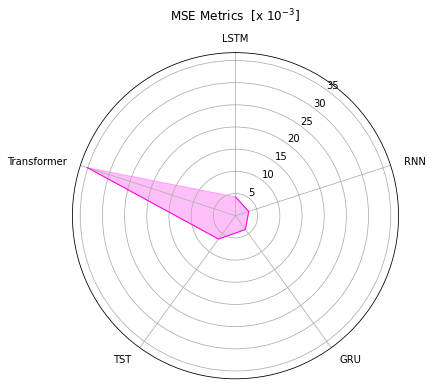

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


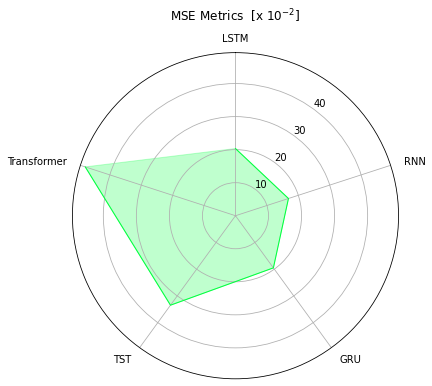

In [9]:
models_labels = calc_result_df['model'].tolist()
print(models_labels)
MSE_Values = (calc_result_df['calculate_MSE']* 1000).tolist() 
PolarPlotMaker(models_labels, MSE_Values, '#FF00E4', polar_legend=r"MSE Metrics  [x $10^{-3}$] ", filename='MSE_Metrics')

MAPE_Values = (calc_result_df['calculate_MAPE'] * 100).tolist()
PolarPlotMaker(models_labels, MAPE_Values, '#00FF3E', polar_legend=r"MSE Metrics  [x $10^{-2}$] ", filename='MaE_Metrics')

In [10]:
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = default_scaler.min_[-1], default_scaler.scale_[-1]

In [11]:
descaled_rnn_prediction = descale(descaler, complete_prediction_df[complete_prediction_df['model'] == 'RNN'].model_output)
descaled_gru_prediction = descale(descaler, complete_prediction_df[complete_prediction_df['model'] == 'GRU'].model_output)
descaled_lstm_prediction = descale(descaler, complete_prediction_df[complete_prediction_df['model'] == 'LSTM'].model_output)
descaled_tst_prediction = descale(descaler, complete_prediction_df[complete_prediction_df['model'] == 'TST'].model_output)
descaled_label = descale(descaler, labels)

# Results

In [12]:
calc_result_df

,calculate_MSE,calculate_RMSE,calculate_MAE,calculate_MAPE,r2,model
0,0.004249,0.065182,0.032485,0.203318,0.891565,LSTM
1,0.003141,0.056045,0.029103,0.168631,0.919836,RNN
2,0.003829,0.061882,0.034918,0.195160,0.902266,GRU
3,0.006505,0.080653,0.049698,0.334738,0.833982,TST
4,0.035163,0.187519,0.162907,0.478139,0.102560,Transformer


In [13]:
calc_result_df

,calculate_MSE,calculate_RMSE,calculate_MAE,calculate_MAPE,r2,model
0,0.004249,0.065182,0.032485,0.203318,0.891565,LSTM
1,0.003141,0.056045,0.029103,0.168631,0.919836,RNN
2,0.003829,0.061882,0.034918,0.195160,0.902266,GRU
3,0.006505,0.080653,0.049698,0.334738,0.833982,TST
4,0.035163,0.187519,0.162907,0.478139,0.102560,Transformer


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


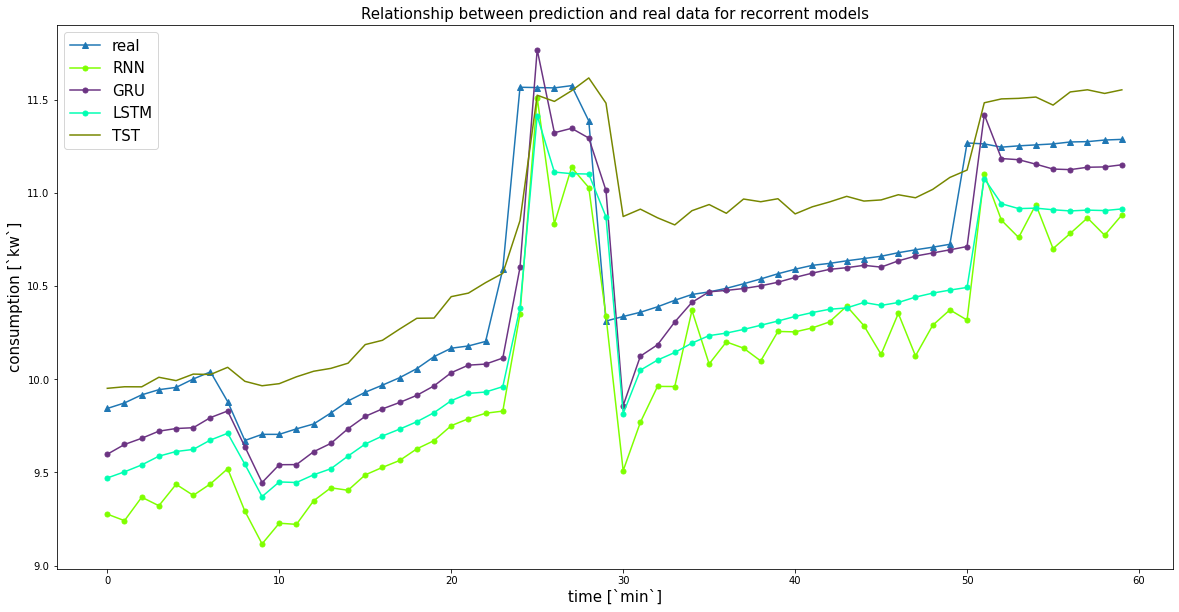

In [16]:
plt.figure(figsize=(20, 10))
plt.title(f'Relationship between prediction and real data for recorrent models', fontsize=15)
plt.plot(descaled_label[:60], '^', ls='-',label='real')
plt.plot(descaled_rnn_prediction[:60], '.', ms = 10, ls = '-', c = '#7FFF00',label='RNN')
plt.plot(descaled_gru_prediction[:60], '.', ms = 10, ls = '-', c = '#6C3483',label='GRU')
plt.plot(descaled_lstm_prediction[:60], '.', ms = 10, ls = '-', c = '#00FFB2',label='LSTM')
plt.plot(descaled_tst_prediction[:60], ms = 10, ls = '-', c = '#778700',label='TST')

plt.xlabel('time [`min`]', fontsize=15)
plt.ylabel('consumption [`kw`]', fontsize=15)
plt.legend(fontsize=15)
plt.savefig(f'methodology/imgs/results/forecasting/all_baseline_models_forecasting.eps', dpi=600, bbox_inches='tight')
plt.savefig(f'methodology/imgs/results/forecasting/all_baseline_models_forecasting.svg', dpi=600, bbox_inches='tight')
plt.savefig(f'methodology/imgs/results/forecasting/all_baseline_models_forecasting.png', dpi=600, bbox_inches='tight')
plt.show()

# Comparativos entre Ensembles

In [ ]:
plt.figure(figsize=(20, 10))
plt.title(f'Relationship between prediction and real data for recorrent models', fontsize=15)
plt.plot(descaled_label[:60], '^', ls='-',label='real')
plt.plot(descaled_sa_avg_ensemble_prediction[:60], '.', ms = 10, ls = '-', c = '#B03A2E',label='SA-RecorrentEnsemble')
plt.plot(descaled_avg_ensemble_prediction[:60], '.', ms = 10, ls = '-', c = '#FF00E4',label='AVG RecorrentEnsemble - Prediction')
plt.plot(descaled_rnn_prediction[:60], '.', ms = 10, ls = '-', c = '#7FFF00',label='RNN - Prediction')

# plt.plot(output, 'm--', label='predictions')

plt.xlabel('time [`min`]', fontsize=15)
plt.ylabel('consumption [`kw`]', fontsize=15)
plt.legend(fontsize=15)
# plt.savefig(f'methodology/imgs/results/forecasting/others_models_forecasting.eps', dpi=600, bbox_inches='tight')
# plt.savefig(f'methodology/imgs/results/forecasting/others_models_forecasting.svg', dpi=600, bbox_inches='tight')
plt.show()